In [1]:
import numpy as np
import copy
import random
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

## Реализуем поле GF(2^6) по модулю многочлена p(x)=x^6+x+1

In [3]:
def polynome_mul(a, b):
    d = i = 0
    while b > 0:
        if b & 1:
            d ^= (a << i)
        b = b >> 1
        i += 1
    return d 

In [4]:
def polynome_div(a, b):
    res = 0
    r = a.bit_length() - b.bit_length()
    while (r >= 0): 
        res += 1 << r
        a ^= b << r
        r = a.bit_length() - b.bit_length()
    return res

In [5]:
def galois_mul(a, b, base_polynome=int("1000011",2)):
    mul = polynome_mul(a, b)
    for i in range(len(bin(mul)) - 2, len(bin(base_polynome)) - 4, -1):
        if ((1 << i) & mul):
            mul ^= base_polynome << i - len(bin(base_polynome)) +3
    return int(mul)


In [6]:
def galois_add(a, b):
    return a^b

In [7]:
def find_inverse(matrix_mul ,a):
    for i in range(len(matrix_mul[int(a-1) % 63])):
        if matrix_mul[int(a-1) %63][i] == 1:
            return i+1
    return 0

In [8]:
matrix_mul = np.zeros((2**6 - 1, 2**6 -1)).astype(int)
matrix_mul[0, :] = np.arange(1, 2**6, 1).astype(int)
matrix_mul[:, 0] = np.arange(1 , 2**6, 1).astype(int)
for i in range(len(matrix_mul)):
    for j in range(len(matrix_mul)):
        matrix_mul[i][j] = galois_mul(i + 1 , j + 1)
matrix_mul

array([[ 1,  2,  3, ..., 61, 62, 63],
       [ 2,  4,  6, ..., 57, 63, 61],
       [ 3,  6,  5, ...,  4,  1,  2],
       ...,
       [61, 57,  4, ..., 46, 42, 23],
       [62, 63,  1, ..., 42, 43, 21],
       [63, 61,  2, ..., 23, 21, 42]])

In [9]:
matrix_pow = np.zeros((2**6 - 1, 2**6 -1)).astype(int)
matrix_pow[0, :] = np.arange(1, 2**6, 1).astype(int)
matrix_pow[:, 0] = np.arange(1 , 2**6, 1).astype(int)
for i in range(len(matrix_mul)):
    for j in range(1, len(matrix_pow)):
        matrix_pow[i][j] = galois_mul(i+1 ,int(matrix_pow[i][j-1]))
matrix_pow

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 2,  4,  8, ..., 49, 33,  1],
       [ 3,  5, 15, ..., 43, 62,  1],
       ...,
       [61, 46, 43, ..., 12, 16,  1],
       [62, 43, 25, ...,  5,  3,  1],
       [63, 42, 13, ..., 48, 32,  1]])

In [10]:
matrix_add = np.zeros((2**6, 2**6)).astype(int)
matrix_add[0, :] = np.arange(2**6).astype(int)
matrix_add[:, 0] = np.arange(2**6).astype(int)
for i in range(len(matrix_add)):
    for j in range(len(matrix_add)):
        matrix_add[i][j] =  galois_add(i, j)
matrix_add

array([[ 0,  1,  2, ..., 61, 62, 63],
       [ 1,  0,  3, ..., 60, 63, 62],
       [ 2,  3,  0, ..., 63, 60, 61],
       ...,
       [61, 60, 63, ...,  0,  3,  2],
       [62, 63, 60, ...,  3,  0,  1],
       [63, 62, 61, ...,  2,  1,  0]])

##  Находим последовательные корни и сопряженные им элементы

In [11]:
classes = {}
array = [x for x in range(1,2**6 - 1, 1)]
mul = 2
count = 1
while(len(array) != 0):
    classes[count] = []
    for i in range(1, 2**6,1):
        a =  count * mul**i %  (2**6 - 1)
        if a in array:
            array.remove(a)
            classes[count].append(a)
    count += 1
classes[0] = [0]
classes

{1: [2, 4, 8, 16, 32, 1],
 2: [],
 3: [6, 12, 24, 48, 33, 3],
 4: [],
 5: [10, 20, 40, 17, 34, 5],
 6: [],
 7: [14, 28, 56, 49, 35, 7],
 8: [],
 9: [18, 36, 9],
 10: [],
 11: [22, 44, 25, 50, 37, 11],
 12: [],
 13: [26, 52, 41, 19, 38, 13],
 14: [],
 15: [30, 60, 57, 51, 39, 15],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [42, 21],
 22: [],
 23: [46, 29, 58, 53, 43, 23],
 24: [],
 25: [],
 26: [],
 27: [54, 45, 27],
 28: [],
 29: [],
 30: [],
 31: [62, 61, 59, 55, 47, 31],
 0: [0]}

## Создаем проверочную матрицу для (63,10,27) БЧХ кода

In [12]:
H = []
H_view = []
polinoms = [int("1100001",2), int("1011",2), int("11",2)]
check_pol = 1
for i in  polinoms:
    check_pol = polynome_mul(check_pol,i)
create_pol = polynome_div(2 ** 63 + 1, check_pol)
for i in range(53):
    parsed_row = list(map(int,list((bin(check_pol)))[2:]))
    row = [0 for x in range(63 - len(parsed_row))]
    row.extend(parsed_row)
    H_view.append("".join(str(x) for x in row))
    H.append(row)
    check_pol = polynome_mul(2, check_pol)
H_view

['000000000000000000000000000000000000000000000000000010011111101',
 '000000000000000000000000000000000000000000000000000100111111010',
 '000000000000000000000000000000000000000000000000001001111110100',
 '000000000000000000000000000000000000000000000000010011111101000',
 '000000000000000000000000000000000000000000000000100111111010000',
 '000000000000000000000000000000000000000000000001001111110100000',
 '000000000000000000000000000000000000000000000010011111101000000',
 '000000000000000000000000000000000000000000000100111111010000000',
 '000000000000000000000000000000000000000000001001111110100000000',
 '000000000000000000000000000000000000000000010011111101000000000',
 '000000000000000000000000000000000000000000100111111010000000000',
 '000000000000000000000000000000000000000001001111110100000000000',
 '000000000000000000000000000000000000000010011111101000000000000',
 '000000000000000000000000000000000000000100111111010000000000000',
 '0000000000000000000000000000000000000010011111

## Создаем порождающую матрицу для (63,10,27) БЧХ кода

In [13]:
G = []
G_view = []
print("Порождающий многочлен - " + (oct(create_pol)))
for i in range(10):
    row = list(map(int,list(reversed(bin(create_pol)))[:-2]))
    row.extend([0 for x in range(63 - len(row))])
    G_view.append("".join(str(x) for x in row))
    G.append(row)
    create_pol = polynome_mul(2, create_pol)
G_view

Порождающий многочлен - 0o472622305527250155


['101101100000101010111010101101000110010010011010111001000000000',
 '010110110000010101011101010110100011001001001101011100100000000',
 '001011011000001010101110101011010001100100100110101110010000000',
 '000101101100000101010111010101101000110010010011010111001000000',
 '000010110110000010101011101010110100011001001001101011100100000',
 '000001011011000001010101110101011010001100100100110101110010000',
 '000000101101100000101010111010101101000110010010011010111001000',
 '000000010110110000010101011101010110100011001001001101011100100',
 '000000001011011000001010101110101011010001100100100110101110010',
 '000000000101101100000101010111010101101000110010010011010111001']

# Процедура кодирования кода

In [14]:
def code(G, u):
    res = [0 for x in range(len(G[0]))]
    for i in range(len(G[0])):
        for j in range(len(u)):
            res[i] ^= (u[j] & G[j][i])
    return res

 ## Находим все кодовые слова

In [15]:
words = []
for i in range(2**10):
    word = list(map(int,list(bin(i))[2:]))
    vec = [0 for x in range(10 - len(word))]
    vec.extend(word)
    words.append(vec)
voc = [code(G, u) for u in words]

# Декодирование кода

## Декодирование по максимуму правдоподобия

In [16]:
def most_suit(voc,v):
    min_dif = 2**63
    res = []
    for word in voc:
        step = np.asarray([word[i] ^ v[i] for i in range(len(v))])
        difference = np.count_nonzero(step == 1)
        if min_dif > difference:
            res = word
            min_dif = difference
    return res
        
            

## Декодирование методом Горенстейна-Петерсона-Цирлера

## Вычисляем синдром 

In [17]:
def get_syndrom(matrix_pow, v, t=13):
    res = []
    s_1 = 0
    for i in range(2 * t):
        s_1= 0
        alpha = int(matrix_pow[1][i])
        for j in range(len(v)):
            s_1 ^= matrix_pow[alpha - 1][j-1] * v[j]
        res.append(s_1)
    return res

## Решение системы линейных уравнений в поле

In [18]:
def solve(matrix_main, vector_main, matrix_mul, n=63):
    matrix = matrix_main.copy()
    vector = vector_main.copy()
    res = [0 for i in range(len(matrix))]
    order = [0 for i in range(len(matrix))]
    t = len(matrix)
    for k in range(1, t):
        for i in range (k, t):
            if(matrix[k-1][k - 1] == 0):
                for z in range(k-1,t):
                    if matrix[z][k-1] != 0:
                        a = matrix[k-1].copy()
                        matrix[k-1] = matrix[z].copy()
                        matrix[z] = a
                        a = vector[k-1]
                        vector[k-1] = vector[z]
                        vector[z] = a
                        break
            save = matrix[i][k - 1]
            step = matrix_mul[(find_inverse(matrix_mul,matrix[k - 1][k - 1]) - 1)%63][(save-1)%n]
            if save ==0:
                continue
            for j in range(k-1,t):
                if matrix[k -1][j]  != 0:
                    matrix[i][j] = matrix[i][j] ^ matrix_mul[(matrix[k -1][j] - 1) % n][(step -1) %n]
            if vector[k-1] != 0:
                vector[i] = vector[i] ^ matrix_mul[(vector[k-1]- 1) % n][(step -1) %n]
    for i in range(t):
        if matrix[i][i] == 0:
            return []
    for i in range(t - 1, -1, -1):
        for j in range(t):
            if(res[j] == 0 or matrix[i][j]==0):
                continue
            res[i] = res[i] ^ matrix_mul[(matrix[i][j]-1)%n][(res[j]-1)%n]
        if (vector[i] ^ res[i]) != 0:
            res[i] = matrix_mul[((vector[i] ^ res[i]) -1)%n][(find_inverse(matrix_mul,matrix[i][i]) - 1)%n]
        else:
            res[i] = 0
    return res

## Получение матрицы локаторов

In [19]:
def make_locator_matrix(s, t=13):
    matrix_locator = np.zeros((t,t)).astype(int)
    s_r = [s[i] for i in range(0, len(s)-1, 2)] 
    sub_matrix = [[1,0]]
    sub_matrix.extend([[s[i+1], s[i]] for i in range(0,len(s)- 2,2)])
    for i in range(0, len(matrix_locator), 2):
        for j in range(0, len(sub_matrix) - i//2,1):
            matrix_locator[j + (i // 2)][i] = sub_matrix[j][0]
            if((i + 1) < len(matrix_locator[0])):
                matrix_locator[j + (i//2)][i +1] = sub_matrix[j][1]
    return matrix_locator, s_r

## Находим индексы в которых произошла ошибка

In [20]:
def get_err_indexes(matrix_locator, s_r, matrix_mul,matrix_pow, n=63):
    i = n
    roots = []
    roots_index = []
    while i > 0:
        pol_loc = solve(matrix_locator[:i,:i], s_r[:i], matrix_mul)
        if pol_loc != []:
            roots = []
            roots_index = []
            for j in range(n):
                pretend = 1
                for k in range(len(pol_loc)):
                    if pol_loc[k] !=0:
                        pretend ^= matrix_mul[(matrix_pow[j][k] -1)%n][((pol_loc[k]) -1)%n]
                if pretend == 0:
                    root = find_inverse(matrix_mul, matrix_pow[j][0])
                    roots.append(root)
                    roots_index.append(int(np.where(matrix_pow[1] == root)[0] + 1) % n)
            if len(roots) != len(pol_loc):
                roots = []
                roots_index = []
            if roots != []:
                break
        i -= 1
    return roots_index


## Моделирование нашего кода

In [21]:
num_of_runs = 100
err_prob_in = np.arange(0, 0.5, 0.02)
err_prob_out = {}
err_prob_out["(63,10,27) Максимум правдоподобия"] =[]
err_prob_out["(63,10,27) ГЦП"] =[]
for p in tqdm(err_prob_in):
    error_count = [0,0]
    for run in (range(num_of_runs)):
        ind = random.randint(0,100)
        vec_most_suit = voc[ind].copy()
        vec_origin = vec_most_suit.copy()
        #make errors
        for i in range(len(vec_most_suit)):
            if random.random() < p:
                vec_most_suit[i]^=1
        vec_gcp = vec_most_suit.copy()
        #find most_suit
        vec_most_suit = most_suit(voc,vec_most_suit)
        if vec_most_suit != vec_origin:
            error_count[0] += 1
        #GCP DECODE
        s = get_syndrom(matrix_pow, vec_gcp)
        if all(x == 0 for x in s):
            continue
        matrix_locator, s_r = make_locator_matrix(s)
        for i in sorted(get_err_indexes(matrix_locator, s_r, matrix_mul,matrix_pow)):
            vec_gcp[i] ^= 1
        if vec_gcp!= vec_origin:
            error_count[1] += 1      
    err_prob_out["(63,10,27) Максимум правдоподобия"].append(error_count[0] / num_of_runs)
    err_prob_out["(63,10,27) ГЦП"].append(error_count[1] / num_of_runs)
       

100%|██████████| 25/25 [08:37<00:00, 25.58s/it]


/Users/Silya/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


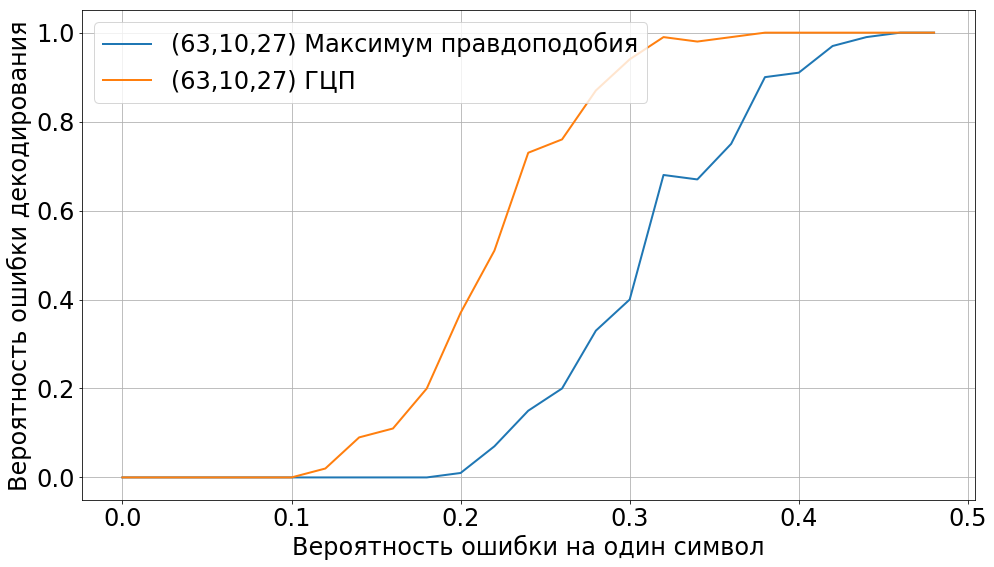

In [22]:
plt.figure(figsize=(16,9))
for name in err_prob_out.keys():
    plt.grid(1)
    plt.plot(err_prob_in, err_prob_out[name], label=name)
    plt.legend()
    plt.xlabel("Вероятность ошибки на один символ")
    plt.ylabel("Вероятность ошибки декодирования")

http://peredacha-informacii.ru/table61.html